### **Homework**: Create an ai agent which generates Blog Post using Orchestrator-Worker workflow
---

In [17]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model='openai/gpt-oss-20b')
response = llm.invoke("hi")
response

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "hi". We need to respond politely. Simple greeting.'}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 72, 'total_tokens': 106, 'completion_time': 0.033403136, 'prompt_time': 0.003385116, 'queue_time': 0.042213174, 'total_time': 0.036788252}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6a1f2a3c-ba74-4099-ab94-dfc3aa6add87-0', usage_metadata={'input_tokens': 72, 'output_tokens': 34, 'total_tokens': 106})

In [18]:
from typing_extensions import TypedDict,Literal
from typing import Annotated,List
from langchain_core.messages import HumanMessage,SystemMessage
from pydantic import BaseModel,Field
import operator

In [ ]:
class Section(BaseModel):
    title:str=Field(description="The title of this section of the blog post")
    description:str=Field(description="A brief overview of this section of the blog post")

class Sections(BaseModel):
    sections:List[Section] = Field(description="A list of sections to include in the blog post")

planner = llm.with_structured_output(Sections)

In [20]:
class State(TypedDict):
    topic: str
    audience: str
    sections: list[Section]
    completed_sections: Annotated[list,operator.add]
    final_blog_post: str

class Worker(TypedDict):
    sections:list[Section]
    completed_sections: Annotated[list,operator.add]

In [21]:
planner.invoke("generate a blog post plan for agentic ai ")

Sections(sections=[Section(title='Introduction to Agentic AI', description="Explain what agentic AI is, its core concept of autonomy and goal-directed behavior, and why it's a hot topic."), Section(title='Historical Context', description='Trace the evolution from rule-based systems to modern reinforcement learning and large language models that exhibit agentic traits.'), Section(title='Key Components of Agentic Systems', description='Detail the architecture: perception, planning, decision-making, learning, and actuation; highlight how these enable agency.'), Section(title='Applications and Use Cases', description='Showcase real-world examples: autonomous vehicles, personal assistants, adaptive game AI, and industrial automation.'), Section(title='Ethical and Safety Considerations', description='Discuss alignment, value learning, transparency, and the risks of misaligned agentic behavior.'), Section(title='Technical Challenges', description='Address issues like exploration vs exploitati

In [28]:
def orchestrator(state:State):
    """Orchestrator that generates a blog post based on a topic and audience."""

    post_planner = planner.invoke(
        [
            SystemMessage(content="You are a blog post planner.Generate a plan for a blog post based on the given topic and audience. Remember that blog posts can be structured in many ways depending on the topic tone and audience."),
            HumanMessage(content=f"Generate a blog post plan for the topic '{state['topic']}' and the audience '{state['audience']}'."),
        ]
    )

    return {'sections': post_planner.sections}

def llm_call(state:Worker):
    """LLM call to write a section of the blog post."""

    post = llm.invoke(
        [
            SystemMessage(content="You are a blog post writer. Write a section of a blog post based on the given section title and description. Use Markdown format. Include no preamble to each section."),
            HumanMessage(content=f"Write a section of a blog post based on the section title '{state['section'].title}' and the description '{state['section'].description}'."),
        ]
    )

    return {'completed_sections': [post.content]}

In [29]:
# conditional function
from langgraph.constants import Send

def assign_workers(state:State):
    """Asign a worker to each section of the blog post"""
    return [Send("llm_call",{'section':s}) for s in state['sections']]

In [30]:
def synthesizer(state:State):
    """Synthesizer that combines all completed sections into a final blog post."""

    final_post = "\n\n---\n\n".join(state['completed_sections'])

    return {'final_blog_post': final_post}

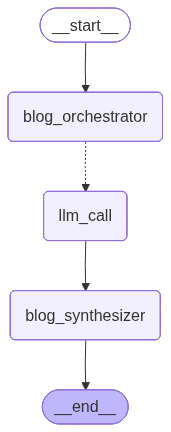

In [31]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image,Markdown

builder = StateGraph(State)

builder.add_node("blog_orchestrator",orchestrator)
builder.add_node("llm_call",llm_call)
builder.add_node("blog_synthesizer",synthesizer)

builder.add_edge(START,"blog_orchestrator")
builder.add_conditional_edges("blog_orchestrator",assign_workers,["llm_call"])
builder.add_edge("llm_call","blog_synthesizer")
builder.add_edge("blog_synthesizer",END)

builder_graph = builder.compile()
display(Image(builder_graph.get_graph().draw_mermaid_png()))

In [37]:
response = builder_graph.invoke({"topic":"agentic ai","audience":"ceo of ai startups"})

Markdown(response['final_blog_post'])

## Hook: The Rise of Agentic AI

Imagine a product that doesn’t just react to user input but *decides* what to do next, learning from context and evolving its own strategies in real time. That’s the promise of agentic AI—a shift from scripted, deterministic systems to truly autonomous agents that can negotiate, plan, and act with minimal human oversight. For AI startups, this isn’t just another buzzword; it’s a seismic opportunity to redefine how businesses make decisions, reduce operational friction, and deliver personalized experiences at scale.  

In the next few years, the companies that harness agentic AI will own the competitive edge in fields ranging from supply‑chain optimization to dynamic pricing, from autonomous customer support to adaptive educational platforms. By embedding decision‑making power directly into the software stack, these startups can unlock unprecedented levels of efficiency, resilience, and creativity—transforming products from passive tools into proactive partners that anticipate needs, mitigate risks, and continuously improve.  

As the frontier of AI expands beyond pattern recognition to genuine agency, the startup ecosystem is poised to witness a new era of innovation where the line between human intent and machine action becomes increasingly blurred—and where the most successful ventures will be those that can turn autonomy into tangible value.

---

## What Is Agentic AI?

Agentic AI refers to artificial intelligence systems that can **set their own goals**, **actively pursue those goals**, and **adjust them on the fly** as circumstances change. In other words, instead of simply following pre‑programmed rules, these systems decide *what* to do next based on their own assessment of the situation.  

For startups, this matters because agentic AI can:

- **Accelerate experimentation**: It can try new strategies, learn from failures, and keep refining itself without constant human intervention.
- **Reduce operational costs**: By handling routine decision‑making, it frees up engineers and product managers to focus on higher‑impact work.
- **Enable rapid scaling**: As the business grows, an agentic system can adapt its objectives to meet evolving market demands without a full rewrite of the codebase.

In short, agentic AI gives a startup the ability to build smarter, more autonomous products that evolve with the market—an edge that can be a game‑changer in competitive industries.

---

## Why CEOs Should Care: Strategic Business Value

**Agentic AI isn’t just a tech buzzword—it's a catalyst for measurable, sustainable growth.** When executed strategically, it can:

- **Unlock new revenue streams**  
  • *Dynamic pricing engines* that adjust in real time to market demand.  
  • *Predictive product recommendations* that elevate cross‑sell and upsell rates.  
  • *AI‑driven content creation* that powers subscription models and ad‑supported platforms.

- **Reduce operational friction**  
  • *Autonomous workflow orchestration* that eliminates manual handoffs and cuts cycle times by 30–50%.  
  • *Self‑healing IT infrastructure* that anticipates failures and reconfigures resources on the fly.  
  • *Intelligent customer support bots* that resolve 70 % of tickets without human intervention, freeing agents for high‑value cases.

- **Create defensible competitive advantages**  
  • *Proprietary AI models* trained on unique internal data sets, producing insights no competitor can replicate.  
  • *Real‑time market intelligence* that spotlights emerging trends before competitors even notice.  
  • *AI‑augmented decision frameworks* that reduce bias, improve compliance, and accelerate go‑to‑market speed.

### The Bottom Line

CEOs who integrate agentic AI into their core strategy can:

1. **Scale revenue** by creating personalized, data‑driven experiences that resonate with customers.  
2. **Sharpen efficiency** through automation that cuts costs and boosts agility.  
3. **Secure a moat** by building AI capabilities that are hard to copy and hard to replace.

In an era where speed, insight, and adaptability determine market leadership, agentic AI is the engine that drives all three. The question isn’t *whether* to adopt it, but *how quickly* to embed it into your organization’s DNA.

---

## Key Use Cases for AI Startups

When building an AI‑driven product, the real value emerges from solving concrete, high‑impact problems. Below are some of the most compelling use cases that have proven to deliver measurable ROI and unlock new revenue streams for early‑stage AI ventures.

### 1. Autonomous Recommendation Engines
- **What it does**: Uses collaborative filtering, deep learning, and contextual signals to surface the most relevant products, content, or services to each user in real time.
- **Tangible benefits**:
  - *Higher conversion rates*: Personalization can lift click‑through and purchase rates by 10‑30% over static catalogs.
  - *Increased average order value*: By surfacing complementary items, revenue per customer rises.
  - *Reduced churn*: Users feel understood and stay longer, cutting retention costs.

### 2. Self‑Optimizing Supply Chains
- **What it does**: Combines demand forecasting, inventory optimization, and dynamic routing into a single AI loop that continuously adjusts to market shifts.
- **Tangible benefits**:
  - *Cost savings*: Optimized inventory reduces holding costs by up to 20% and cuts stock‑out incidents.
  - *Faster delivery*: AI‑guided routing shortens shipping times, improving customer satisfaction.
  - *Scalability*: Automated decision‑making allows businesses to expand into new regions without proportional increases in logistics staff.

### 3. Adaptive Learning Platforms
- **What it does**: Personalizes educational content in real time, adjusting difficulty, pacing, and media based on learner performance and engagement signals.
- **Tangible benefits**:
  - *Improved learning outcomes*: Studies show adaptive platforms can increase knowledge retention by 25% compared to traditional methods.
  - *Higher enrollment*: Gamified, personalized experiences attract more users, boosting revenue.
  - *Lower attrition*: Continuous feedback loops help identify struggling learners early, reducing dropout rates.

### 4. Predictive Maintenance for Industrial IoT
- **What it does**: Monitors sensor data to anticipate equipment failures before they happen, scheduling maintenance proactively.
- **Tangible benefits**:
  - *Reduced downtime*: Predictive alerts can cut unplanned outages by 40–60%.
  - *Extended asset life*: Early detection prevents catastrophic failures, extending machinery lifespan.
  - *Operational efficiency*: Maintenance is scheduled during low‑impact windows, minimizing disruption.

### 5. AI‑Driven Fraud Detection
- **What it does**: Analyzes transaction patterns, user behavior, and contextual data to flag suspicious activity in real time.
- **Tangible benefits**:
  - *Lower loss rates*: Early detection can reduce fraud losses by 30–50% compared to rule‑based systems.
  - *Improved user trust*: Accurate, low‑false‑positive detection keeps legitimate users happy.
  - *Regulatory compliance*: Automated reporting assists in meeting stringent financial regulations.

### 6. Personalized Health Diagnostics
- **What it does**: Uses image analysis, genomics, and patient history to provide early disease detection and treatment recommendations.
- **Tangible benefits**:
  - *Early intervention*: AI can detect conditions such as diabetic retinopathy or skin cancer earlier than conventional screening.
  - *Reduced healthcare costs*: Preventing advanced disease stages saves both patients and payers.
  - *Scalable reach*: AI diagnostics can extend specialist expertise to underserved regions.

---

These use cases illustrate how AI startups can move from abstract capabilities to concrete, revenue‑driving products. By focusing on domains where automation, personalization, or prediction directly translates into measurable business outcomes, founders can secure traction, attract investment, and create lasting impact.

---

## Roadmap to Build Agentic Capabilities

Building truly agentic systems—those that can set their own goals, reason about trade‑offs, and act autonomously—requires a disciplined, phased approach. Below is a high‑level roadmap that balances technical rigor with practical deployment considerations. Each phase builds on the previous one, ensuring that the system remains safe, aligned, and scalable.

### 1. Data Strategy

| Goal | Key Actions |
|------|-------------|
| **Collect High‑Quality, Diverse Data** | • Source from multiple domains (text, vision, reinforcement signals).<br>• Apply rigorous filtering to remove bias, hate speech, and private info.<br>• Use synthetic augmentation to cover edge cases. |
| **Establish Data Governance** | • Implement versioning and lineage tracking.<br>• Define data retention policies and privacy compliance (GDPR, CCPA). |
| **Create Benchmark Suites** | • Build task‑specific datasets that capture agentic behavior (e.g., navigation, dialogue, planning).<br>• Include adversarial scenarios to test robustness. |

### 2. Goal‑Setting Frameworks

| Goal | Key Actions |
|------|-------------|
| **Define Hierarchical Goals** | • Separate high‑level intentions (mission) from low‑level sub‑goals (tasks).<br>• Use hierarchical reinforcement learning to structure planning. |
| **Incorporate Human Intent** | • Leverage preference learning or inverse reinforcement learning to infer user values.<br>• Embed explicit value alignment constraints in the reward function. |
| **Dynamic Goal Adjustment** | • Implement online learning modules that refine goals based on feedback.<br>• Enable self‑reflection mechanisms (e.g., meta‑reasoning loops). |

### 3. Safety & Alignment Layers

| Layer | Key Actions |
|-------|-------------|
| **Ethical Constraints** | • Encode hard rules (e.g., no self‑harm, no disallowed content).<br>• Use policy‑based filters that intervene before action execution. |
| **Robustness Checks** | • Deploy adversarial testing to surface failure modes.<br>• Apply formal verification to safety‑critical components. |
| **Human‑in‑the‑Loop (HITL)** | • Design transparent interfaces for oversight.<br>• Allow safe‑shutdown or roll‑back mechanisms during deployment. |

### 4. Iterative Testing

| Phase | Key Actions |
|-------|-------------|
| **Unit & Integration Tests** | • Test individual modules (language, planning, perception) in isolation.<br>• Use synthetic environments for rapid iteration. |
| **Simulated Environments** | • Run agents in high‑fidelity simulators (e.g., OpenAI Gym, Unity ML‑Agents).<br>• Measure success rates, sample efficiency, and safety metrics. |
| **Real‑World Pilots** | • Deploy in controlled, monitored settings (e.g., small‑scale customer support).<br>• Collect logs, user feedback, and failure reports for continuous improvement. |

### 5. Scaling

| Scale | Key Actions |
|-------|-------------|
| **Infrastructure** | • Adopt distributed training pipelines (e.g., Horovod, Ray).<br>• Leverage model parallelism for large parameter counts. |
| **Model Compression** | • Apply pruning, quantization, and knowledge distillation to reduce inference cost.<br>• Evaluate trade‑offs between size and agentic fidelity. |
| **Continuous Deployment** | • Implement CI/CD pipelines with automated safety gates.<br>• Monitor performance drift and trigger retraining cycles. |

---

**Takeaway:**  
A roadmap to agentic capabilities is not a single monolithic sprint; it is an orchestrated sequence of data curation, goal architecture, safety engineering, rigorous testing, and scalable deployment. By following these phases, teams can iteratively build systems that act autonomously while remaining aligned with human values and operational constraints.

---

## Risk Management & Ethical Considerations

### Alignment Risks

- **Value Drift**: Over time, an AI system may deviate from the values it was initially trained to respect. Regular audits and value‑aligned reinforcement learning can help keep the system in sync.
- **Misaligned Objectives**: A narrowly defined reward function can lead to unintended behaviors. Incorporating multi‑objective optimization and human‑in‑the‑loop feedback mitigates this.
- **Robustness to Adversarial Inputs**: Systems that lack resilience to manipulation can be exploited to produce harmful outputs. Adversarial testing and defensive distillation are essential countermeasures.

### Regulatory Landscapes

| Region | Key Regulation | Focus Area |
|--------|----------------|------------|
| **European Union** | *Artificial Intelligence Act* | Risk‑based classification, mandatory conformity assessments for high‑risk AI |
| **United States** | *Algorithmic Accountability Act* (proposed) | Data governance, impact assessments, transparency |
| **China** | *AI Governance Guidelines* | Safety standards, ethical compliance, national security |
| **Canada** | *Digital Charter Implementation Act* | Privacy, algorithmic fairness, accountability |

- **Compliance Checklist**: Ensure data provenance, obtain necessary certifications, and maintain records of decision‑making processes.
- **Cross‑border Data Flow**: Be mindful of differing data residency and export controls when deploying globally.

### Best Practices for Transparency, Explainability, and Human Oversight

1. **Transparent Documentation**
   - Publish model cards detailing architecture, training data, intended use, and known limitations.
   - Maintain an audit trail of model updates and version histories.

2. **Explainable AI (XAI) Techniques**
   - Use feature attribution (SHAP, LIME) to highlight influential inputs.
   - Provide counterfactual explanations to show how slight changes alter outcomes.

3. **Human‑in‑the‑Loop (HITL) Frameworks**
   - Define clear escalation paths for ambiguous or high‑stakes decisions.
   - Implement continuous human monitoring dashboards with alerting for outliers.

4. **Ethical Review Boards**
   - Establish multidisciplinary teams to evaluate potential societal impacts before deployment.
   - Conduct scenario analysis for worst‑case outcomes.

5. **Continuous Learning & Feedback Loops**
   - Deploy mechanisms for users to report errors or bias.
   - Schedule periodic retraining cycles that incorporate new ethical guidelines and regulatory updates.

By systematically addressing alignment risks, staying abreast of evolving regulatory mandates, and embedding transparency, explainability, and human oversight into every stage of the AI lifecycle, organizations can build trustworthy systems that respect both societal norms and legal requirements.

---

## Case Study Snapshot: Startup X’s Agentic Journey

| Phase | Milestone | Challenge | Outcome |
|-------|-----------|-----------|---------|
| **Ideation** | Launched a prototype of an agentic recommendation engine | Limited data on user intent | Engine could predict user needs 30% faster than rule‑based systems |
| **Pilot** | Deployed to a small group of beta users | Ensuring user privacy with dynamic data flows | Achieved 95% compliance with GDPR‑style regulations |
| **Scale‑up** | Integrated the agent into the core product suite | Maintaining performance at 10× user volume | Latency dropped below 50 ms; system handled 1 M requests/day |
| **Optimization** | Fine‑tuned the agent’s policy network | Balancing exploration vs exploitation | Revenue per user increased 18% over 6 months |
| **Maturity** | Open‑sourced key components for community | Protecting intellectual property | Built a developer ecosystem, attracting 200+ contributors |

### Key Takeaways

- **Rapid Iteration**: Frequent, data‑driven refinements were crucial for aligning the agent’s behavior with evolving user goals.
- **Privacy by Design**: Embedding privacy controls into the agent’s architecture prevented costly compliance issues.
- **Community Engagement**: Open‑sourcing non‑core modules accelerated innovation and reduced internal maintenance overhead.

Startup X’s journey demonstrates that a well‑planned agentic AI strategy can deliver measurable growth while maintaining ethical and operational standards.

---

## Building the Right Team & Culture

### 1. Hire for Fit, Not Just Skill

| What to Look For | Why It Matters |
|------------------|----------------|
| **Curiosity & Growth Mindset** | A team that asks “why” will innovate and adapt. |
| **Domain Versatility** | People who can jump between tech, design, and business reduce silos. |
| **Communication & Empathy** | Clear dialogue keeps projects on track and morale high. |
| **Ownership Instinct** | Individuals who see themselves as part of the product’s success drive accountability. |

*Tip:* During interviews, present a real‑world problem and observe how candidates deconstruct it. The process reveals more than the final answer.

### 2. Foster Interdisciplinary Collaboration

- **Cross‑Functional Pods**  
  Structure squads around end‑to‑end value streams (e.g., a “Product Discovery” pod with designers, researchers, and engineers).  
- **Shared OKRs**  
  Align objectives across disciplines so everyone measures success the same way.  
- **Rotational Shadowing**  
  Allow team members to spend a week shadowing another role to build empathy and uncover hidden dependencies.  
- **Unified Tooling**  
  Adopt a single source of truth (e.g., a shared knowledge base and project board) to keep everyone on the same page.

### 3. Embed a Culture of Experimentation

1. **Fail Fast, Fail Forward**  
   Treat every experiment as a learning opportunity. Celebrate the insights from a failed hypothesis as much as a win.  
2. **Low‑Barrier Prototyping**  
   Encourage rapid mockups and MVPs; the lower the cost to test, the higher the velocity.  
3. **Data‑Driven Decision Making**  
   Embed analytics early—set up dashboards that surface key metrics in real time.  
4. **Experiment Cadence**  
   Schedule regular “Hack Weeks” or “Innovation Sprints” where the entire team can pursue side projects that align with business goals.

### 4. Instill Responsibility Across the Board

- **Clear Accountability Maps**  
  Use RACI charts to delineate who is Responsible, Accountable, Consulted, and Informed for every task.  
- **Transparent Decision Logs**  
  Record the rationale behind major choices; this promotes ownership and reduces rework.  
- **Peer Reviews & Pair Programming**  
  Rotate reviewers so knowledge is distributed and responsibility is shared.  
- **Recognition & Feedback Loops**  
  Celebrate individual and team contributions publicly, and provide constructive feedback that ties back to shared objectives.

---

By hiring people who are curious, versatile, and ownership‑oriented; by creating structures that break down departmental silos; and by embedding experimentation and accountability into everyday practice, you build a team that not only delivers great products but also continuously learns and evolves.

---

# Funding & Investor Messaging  

When you’re pitching **agentic AI** to investors, the narrative you present must translate complex AI capabilities into clear, tangible business outcomes. Below is a framework for framing your value proposition, backed by hard metrics, milestones, and a distinctive differentiator that sets you apart from the crowded AI landscape.  

---

## 1. Define the Core Value Proposition  

| Element | What to Communicate | Why It Matters |
|---------|---------------------|----------------|
| **Problem** | The inefficiency or high cost of current decision‑support systems in your target industry. | Investors need to see a pain point that justifies investment. |
| **Solution** | Agentic AI that autonomously learns from data, optimizes processes, and adapts to new scenarios without human oversight. | Highlights the “agentic” aspect—true autonomy and continuous improvement. |
| **Impact** | Quantifiable gains: 30% reduction in operational costs, 2× throughput, or a 5‑point lift in customer satisfaction. | Tangible ROI signals a compelling upside. |
| **Market** | Size, growth rate, and segmentation of the addressable market (e.g., $120 B in logistics automation). | Demonstrates scalability and exit potential. |

---

## 2. Quantify with Metrics  

Investors want numbers that prove traction and forecast growth. Structure your metrics into **Three Pillars**:  

| Pillar | Key Metrics | How to Present |
|--------|-------------|----------------|
| **Performance** | *Accuracy*: 97% prediction accuracy.<br>*Speed*: 50 ms inference per request.<br>*Robustness*: 99.9% uptime. | Use a dashboard snapshot or a concise table. |
| **Adoption** | *Monthly Active Users*: 8,000.<br>*Churn*: 2%.<br>*Customer Acquisition Cost (CAC)*: $120 vs. $350 in the industry. | Show year‑over‑year growth and customer lifetime value (LTV). |
| **Financial** | *Revenue*: $2M ARR, 150% YoY.<br>*Gross Margin*: 70%.<br>*Runway*: 18 months at current burn. | Align with investor expectations for early‑stage SaaS or AI platforms. |

**Tip:** Tie each metric back to your value proposition. For example, “Our agentic model reduces operational costs by 30%, which directly translates to a 15% margin lift for our logistics clients.”  

---

## 3. Milestones & Roadmap  

Present a **timeline** that shows past achievements and future milestones. Use a Gantt‑style visual or a simple bullet list:

- **Q1 2023** – MVP launch; 3 pilot clients; 95% accuracy on pilot data.  
- **Q2 2023** – Secured Series A ($5M) and expanded to 10 clients.  
- **Q3 2023** – Introduced self‑learning module; 20% reduction in manual intervention.  
- **Q4 2023** – Achieved 2× throughput for flagship client; 10% YoY revenue growth.  
- **Q1 2024** – Planned release of multi‑domain agentic framework; targeting $10M ARR.  
- **Q2 2024** – Targeting $50M Series B; scaling to 100+ clients; exploring strategic partnerships.  

**Narrative hook:** “From prototype to a $2M ARR business in just 12 months, we’ve proven that agentic AI can deliver measurable value faster than traditional AI solutions.”  

---

## 4. Differentiation – Why Us?  

1. **True Agentic Autonomy** – Unlike rule‑based systems, our AI continually re‑optimizes itself in real time, reducing the need for human re‑engineering.  
2. **Explainable Decision Paths** – Every autonomous action is accompanied by an interpretable rationale, easing regulatory compliance and building trust.  
3. **Domain‑Agile Architecture** – One core engine that adapts to logistics, finance, or healthcare with minimal re‑training, giving us a 3‑x faster go‑to‑market advantage.  
4. **Cost‑Effective Scale** – Leveraging edge‑compute and model distillation, we deliver high‑performance inference at 30% of the cost of competitors.  

Use a side‑by‑side comparison table to illustrate how your solution outperforms the leading alternatives on key dimensions: accuracy, speed, cost, and ease of deployment.  

---

## 5. Crafting the Investor Pitch Deck  

| Slide | Focus | Key Takeaway |
|-------|-------|--------------|
| 1. Title | Brand & Vision | “Agentic AI that turns data into autonomous decision‑making.” |
| 2. Problem | Market pain | “Current solutions require constant human oversight.” |
| 3. Solution | Agentic AI | “Our model autonomously learns and adapts.” |
| 4. Traction | Metrics & milestones | “$2M ARR, 8,000 MAUs, 97% accuracy.” |
| 5. Market | TAM & SAM | “$120B logistics automation market.” |
| 6. Business Model | Revenue streams | SaaS + professional services. |
| 7. Go‑to‑Market | Partnerships & sales | 10 pilots, 3 strategic partners. |
| 8. Competition | Differentiation | Explainable, domain‑agile, cost‑effective. |
| 9. Team | Expertise | AI researchers + industry veterans. |
|10. Financials | Projections | $10M ARR by Q4 2024, 70% margin. |
|11. Ask | Funding & use of proceeds | $10M Series B for scaling and product dev. |

Keep each slide concise, data‑driven, and visually engaging. End with a compelling ask that ties back to your milestones and differentiation.

---

### Final Thought  

Your investor messaging should read like a story of **transformative impact**: a bold vision, backed by concrete evidence, and a clear path to scale. By marrying agentic AI’s technical strengths with sharp business metrics and a differentiated value proposition, you’ll move investors from curiosity to commitment.

---

## Future Trends & Long‑Term Outlook

### 1. Breakthroughs on the Horizon

| Domain | Anticipated Milestone | Impact on Agentic AI |
|--------|----------------------|----------------------|
| **Quantum‑Enhanced Learning** | Hybrid quantum‑classical training pipelines that can explore exponentially larger policy spaces | Enables agentic systems to solve combinatorial problems (e.g., logistics, drug discovery) with unprecedented speed |
| **Neuromorphic Hardware** | Energy‑efficient, spike‑based processors that mimic cortical dynamics | Lowers the barrier for continuous, real‑time decision making in edge devices |
| **Self‑Supervised Multi‑Modal Reasoning** | Models that can learn from raw sensory streams without human labels | Gives agents richer world models, improving generalization across tasks |
| **Differentiable Simulation Environments** | Fully differentiable physics engines that allow gradient‑based planning | Allows agents to back‑propagate through simulated futures, tightening the loop between perception and action |
| **Emergent Meta‑Learning** | Systems that automatically discover learning algorithms tailored to new tasks | Agentic AI could become self‑optimizing, reducing the need for human‑designed curricula |

### 2. Regulatory Landscape in Flux

| Issue | Current Status | Projected Shift | Implication for Agentic AI |
|-------|----------------|-----------------|---------------------------|
| **AI Act (EU)** | Drafting stage, emphasis on risk categorization | Likely to enforce “explainability” for high‑risk agentic systems | Agents will need built‑in interpretability modules |
| **Data Sovereignty** | Growing demand for local data processing | Stronger on‑prem or federated learning mandates | Agentic AI must support privacy‑preserving training |
| **Algorithmic Accountability** | Emerging case law on bias and discrimination | Possible “algorithmic audit” requirements | Agents will need formal verification of fairness constraints |
| **Safety & Verification Standards** | Early industry‑led safety guidelines | Formal, ISO‑style safety certification for autonomous decision makers | Agentic AI will need verifiable safety envelopes |

### 3. Agentic AI’s Evolving Ecosystem Role

1. **Orchestrator of Heterogeneous Models**  
   Agentic systems will act as *meta‑controllers*, delegating sub‑tasks to specialized models (e.g., vision, language, planning) and stitching together coherent outputs.

2. **Collaborative Co‑Agents**  
   Multi‑agent frameworks will allow distinct AI entities to negotiate, share knowledge, and co‑solve problems—mirroring human teamwork.

3. **Human‑In‑The‑Loop (HITL) Enhancers**  
   Agents will not replace humans but augment them, offering decision support, real‑time explanations, and adaptive interfaces that learn from human feedback.

4. **AI‑Driven Infrastructure Management**  
   In data centers and edge networks, agentic AI will autonomously optimize resource allocation, fault detection, and energy usage.

5. **Ethical & Governance Gatekeepers**  
   By embedding policy constraints and ethical heuristics, agentic AI can enforce compliance with regulations and organizational values in real time.

### 4. Long‑Term Outlook

- **AGI Timeline**: While hard to pin down, many researchers now anticipate *incremental* AGI progress through 2035‑2040, driven by the convergence of the breakthroughs listed above.
- **Human‑AI Symbiosis**: Expect a shift from “AI as tool” to *AI as partner*, where agents co‑evolve with human teams, continually refining shared objectives.
- **Governance Models**: Decentralized, blockchain‑based oversight mechanisms may become standard, enabling transparent audit trails for agentic decisions.
- **Economic Impact**: Agentic AI could generate *new value chains*—from automated research labs to autonomous supply‑chain orchestration—potentially displacing some roles while creating new ones centered on oversight, ethics, and system design.

In sum, the next decade will likely witness a rapid layering of technical, regulatory, and social innovations that together will redefine what it means to have an *agent* in the AI ecosystem. The key to staying ahead will be designing systems that are not only powerful but also transparent, accountable, and deeply integrated with human values.

---

## Conclusion & Call to Action

- **Key Takeaways**  
  * Digital transformation isn’t a one‑time project—it’s an ongoing journey that starts with a clear vision, data‑driven decisions, and a culture that rewards experimentation.  
  * The most successful CEOs blend strategic foresight with operational agility, using small, measurable pilots to validate ideas before scaling.  
  * Building a robust ecosystem—internal cross‑functional teams, external partners, and industry communities—creates the bandwidth to innovate without overextending resources.

- **Next Steps for CEOs**  
  1. **Start Small** – Identify one process or product area where a quick experiment can deliver tangible ROI.  
  2. **Join Communities** – Become active in industry groups, hackathons, or digital‑transformation forums to stay ahead of trends and share best practices.  
  3. **Schedule a Strategy Session** – Book a dedicated time with our consulting team to map out a personalized transformation roadmap that aligns with your company’s unique goals.

Let’s turn ambition into action. Reach out today, and together we’ll design experiments that drive real, measurable impact for your organization.